In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

In [154]:
banking = pd.read_csv('banking_data.csv')
banking.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [155]:
#banking['y'] = pd.CategoricalDtype(categories=['0','1'], ordered=False)

#banking['y'].dtype
banking['y'] = banking['y'].apply(lambda x: False if x == 0 else True)
banking['y']

0        False
1        False
2         True
3        False
4         True
         ...  
41183    False
41184    False
41185    False
41186    False
41187    False
Name: y, Length: 41188, dtype: bool

In [156]:
banking_cont = banking[['age', 'campaign', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m']]
banking_cont.head()

,age,campaign,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m
0,44,1,0,1.4,93.444,-36.1,4.963
1,53,1,0,-0.1,93.200,-42.0,4.021
2,28,3,2,-1.7,94.055,-39.8,0.729
3,39,2,0,-1.8,93.075,-47.1,1.405
4,55,1,1,-2.9,92.201,-31.4,0.869


In [157]:
logit_reg = LogisticRegression(penalty='none')
logit_reg.fit(banking_cont, banking['y'])
logit_reg.classes_

array([False,  True])

In [158]:
names = banking_cont.columns.values
names
beta = logit_reg.coef_[0]
beta
for i in range(len(names)):
    print(f'Predictor {names[i]} has a coefficient of {beta[i]}')
print(f'The intercept is {logit_reg.intercept_[0]}')

Predictor age has a coefficient of 0.0024588894986585156
Predictor campaign has a coefficient of -0.05765070794521977
Predictor previous has a coefficient of 0.25613079592995935
Predictor emp_var_rate has a coefficient of 0.2742907047013618
Predictor cons_price_idx has a coefficient of 0.03243781954460187
Predictor cons_conf_idx has a coefficient of 0.06701312672406218
Predictor euribor3m has a coefficient of -0.7582284366967778
The intercept is -0.01981072583189497


In [159]:
true_proba = logit_reg.predict_proba(banking_cont)[:,1]
true_proba
results = pd.DataFrame({
    'Actual':banking['y'],
    'Predicted Prob':true_proba
})
results

,Actual,Predicted Prob
0,False,0.060859
1,False,0.056532
2,True,0.438592
3,False,0.149896
4,True,0.436877
...,...,...
41183,False,0.048576
41184,False,0.055594
41185,False,0.054126
41186,False,0.421487


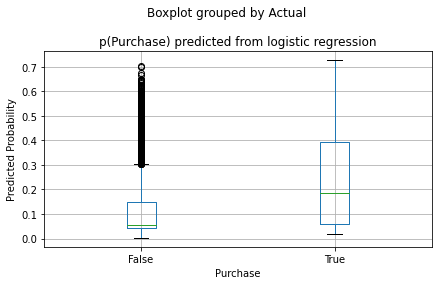

In [160]:
results.boxplot(column='Predicted Prob', by='Actual')
plt.tight_layout()
plt.ylabel('Predicted Probability')
plt.xlabel('Purchase')
plt.title('p(Purchase) predicted from logistic regression')
plt.show()

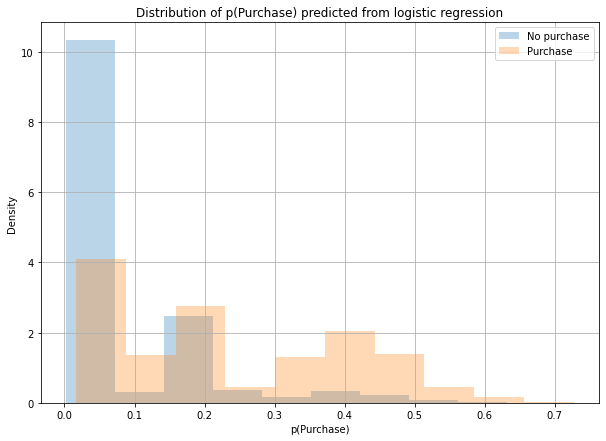

In [161]:
g = results.groupby('Actual')
fig, ax1 = plt.subplots(1, 1, figsize=(10,7))
(ax_false, ax_true) = g.hist(column=['Predicted Prob'], ax = ax1, 
                             alpha=0.3, legend=False, density=True)
ax1.legend(['No purchase', 'Purchase'])
ax1.set_xlabel('p(Purchase)')
ax1.set_ylabel('Density')
ax1.set_title('Distribution of p(Purchase) predicted from logistic regression')
plt.show()

In [162]:
results['Predicted Class'] = logit_reg.predict(banking_cont)
results

,Actual,Predicted Prob,Predicted Class
0,False,0.060859,False
1,False,0.056532,False
2,True,0.438592,False
3,False,0.149896,False
4,True,0.436877,False
...,...,...,...
41183,False,0.048576,False
41184,False,0.055594,False
41185,False,0.054126,False
41186,False,0.421487,False


In [173]:
group = results.groupby('Actual')['Predicted Prob'].mean()
group

Actual
False    0.096927
True     0.237340
Name: Predicted Prob, dtype: float64

In [163]:
print(results.Actual.value_counts())

False    36548
True      4640
Name: Actual, dtype: int64


In [164]:
tn,fp,fn,tp = confusion_matrix(results['Actual'], results['Predicted Class']).ravel()
print(tn,fp,fn,tp)

36331 217 4348 292


We have 36331 true negatives + 292 true positive predictions and 4348 false negatives + 217 false positive predictions.

In [165]:
pos_predict = results.loc[results['Predicted Class']]
neg_predict = results.loc[np.logical_not(results['Predicted Class'])]
num_pos = len(pos_predict)
num_neg = len(neg_predict)
print(num_pos)
print(num_neg)

509
40679


In [166]:
total = len(results)

In [185]:
print(f'Accuracy = {round((tp + tn)/total,2)}, this is the proportion of all correctly identified positives and negatives.')
print(f'Precision = {round(tp/(tp+fp),2)}, this is the proportion of how good our model is with positive identification')
print(f'Recall = {round(tp/(tp+fn),2)}, this is the proportion of true positives that were correctly identified. This can also be known \nas Sensitivity')
print(f'Specificity = {round(tn/(tn+fp),2)}, this is the proportion of true negatives that were correctly identified.')

Accuracy = 0.89, this is the proportion of all correctly identified positives and negatives.
Precision = 0.57, this is the proportion of how good our model is with positive identification
Recall = 0.06, this is the proportion of true positives that were correctly identified. This can also be known 
as Sensitivity
Specificity = 0.99, this is the proportion of true negatives that were correctly identified.


In [168]:
print(classification_report(results['Actual'], results['Predicted Class']))

              precision    recall  f1-score   support

       False       0.89      0.99      0.94     36548
        True       0.57      0.06      0.11      4640

    accuracy                           0.89     41188
   macro avg       0.73      0.53      0.53     41188
weighted avg       0.86      0.89      0.85     41188



In [186]:
f_beta= precision_recall_fscore_support(
    results.Actual, results['Predicted Class'], average='binary')[2]
round(f_beta,2)

0.11

The f_beta score (f1-score above) is a weighted harmonic mean between the precision and recall. The f_beta reaches its best value at 1.0 and worst value at 0.0. The score weights the recall more than the precision by a factor of beta. Beta = 1 means both are equally important. \
We can see that the f_beta score for this model is rather atrocious at 0.11.

From this we can see that the model struggles to identify positive purchases, with a recall of just 0.06. This is because it identified 292 true positives with 4348 false negatives, e.g it missed more than 4000 predictions that should have been positive. \
This is most likely because the prediction threshold of 0.50 is too high. With the groupby mean function above we can see that the mean predicted probability for False is 0.09 and True is 0.23. Lowering the threshold could increase our ability to predict true positives but may also increase our number of false positives.

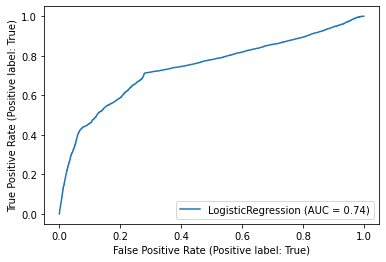

In [179]:
d = plot_roc_curve(logit_reg, banking_cont, banking.y)

Curve shows the trade-off between sensitivity and specificity when the threshold probability used in the classification changes. The area under the curve is a measure of the performance of the classifier that does not depend on the probability threshold used for classification. A completely random classifier has an AUC of 0.5.